In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Solution:
    # one instance of problem solution
    def __init__(self, value):
        self.value = value
        self.dominates = []
        self.dominated_cardinal = 0
        self.rank = None

In [100]:
def visualize(population):
    for s in population:
        color = 'm'
        if s.rank != None:
            if s.rank % 3 == 1:
                color = 'r'
            elif s.rank % 3 == 2:
                color = 'g'
            else:
                color = 'b'
        plt.scatter(*s.value, c=color)

    plt.show()

In [4]:
def fast_non_dominated_sort(population):
    '''
    Accepts a list of Solutions, for each solution instance
    modifies its rank according to the sorting result.
    
    Returns list of fronts, each of which is a list of
    solutions. fronts[0] is the nondominated front.
    '''
    
    fronts = []
    fronts.append([])
    
    '''
    For each solution, assign a list of solutions it dominates
    to 'dominates' field. Assign a number of solutions that
    dominate it to 'dominated_cardinal' field.
    '''
    for p in population:
        for q in population:
            domination = dominates(p,q)
            if domination == 1:
                p.dominates.append(q)
            elif domination == -1:
                p.dominated_cardinal += 1
        if p.dominated_cardinal == 0:
            p.rank = 1
            fronts[0].append(p)
    
    '''
    Peel fronts one by one, from nondominated to
    the worst one.
    '''
    i = 0
    while len(fronts[i]) != 0:
        next_front = []
        for p in fronts[i]:
            for q in p.dominates:
                q.dominated_cardinal -= 1
                if q.dominated_cardinal == 0:
                    q.rank = i + 2
                    next_front.append(q)
        i += 1
        fronts.append(next_front)
    
    fronts.pop()
    return fronts

In [5]:
def dominates(p,q):
    '''
    Returns 1 if p dominates q, -1
    if q dominates p, 0 otherwise.
    '''
    if p.value[0] >= q.value[0] and p.value[1] >= q.value[1]:
        return 1
    elif p.value[0] <= q.value[0] and p.value[1] <= q.value[1]:
        return -1
    else:
        return 0

In [6]:
def get_reference_points(divisions):
    '''
    Generates a list of points that divide each
    goal axis by specified number of divisions.
    TODO: Extend to more then two axes.
    '''
    coords = np.zeros((divisions+1,))
    coords[:divisions] = np.arange(0,1,1/divisions)
    coords[divisions] = 1
    return np.array([[x,y] for x,y in zip(coords,reversed(coords))])

print(get_reference_points(4))

[[0.   1.  ]
 [0.25 0.75]
 [0.5  0.5 ]
 [0.75 0.25]
 [1.   0.  ]]


In [7]:
def normalize(candidate_scores, nondom_scores):
    '''
    Normalizes scores if candidate solutions according
    to NSGA-III specification.
    '''
    ideal_point = np.min(candidate_scores, axis=0)
    
    '''
    This fragment is almost entirely copied from
    official implementation by Deb and his students
    since the paper itself is not very clear on this calculation.
    
    It basically finds solutions that are closest to each axis
    among nondominated solutions. Resulting points are saved as
    'maximum' points.
    '''
    weights = np.eye(candidate_scores.shape[1])
    weights[weights==0] = 1e6
    
    asf = np.max(nondom_scores * weights[:,None,:], axis=2)
    I = np.argmin(asf, axis=1)
    
    maximum = nondom_scores[I,:]
    
    '''
    Find intercepts of a hyper plane generated by 'maximum'
    points.
    '''
    points = maximum - ideal_point
    b = np.ones(points.shape[1])
    plane = np.linalg.solve(points, b)
    intercepts = 1/plane
    
    return (candidate_scores - ideal_point)/intercepts

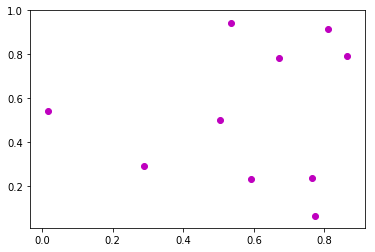

In [99]:
# prepare test population
popsize = 10
values = np.random.random_sample((popsize,2))

initial_population = []

for v in values:
    initial_population.append(Solution(v))

visualize(initial_population)

In [9]:
nondom = fast_non_dominated_sort(initial_population)

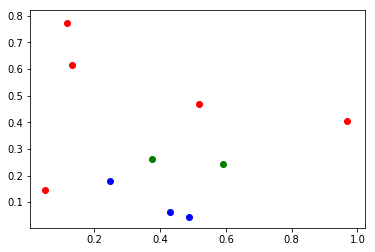

In [10]:
visualize(initial_population)

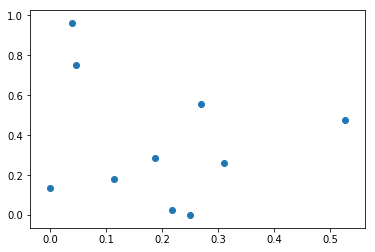

In [11]:
normalized_pop = normalize(np.array([s.value for s in initial_population]),
          np.array([s.value for s in nondom[0]]))
plt.scatter(normalized_pop[:,0], normalized_pop[:,1])
plt.show()

[[0.   1.  ]
 [0.25 0.75]
 [0.5  0.5 ]
 [0.75 0.25]
 [1.   0.  ]]


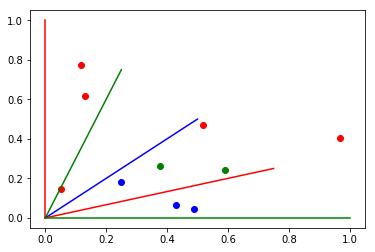

In [12]:
reference_points = get_reference_points(4)
print(reference_points)
for i, r in enumerate(reference_points):
    if i%3 == 0:
        c='r'
    elif i%3 == 1:
        c='g'
    else:
        c='b'
    plt.plot([ 0, r[0]], [0, r[1]], c)
visualize(initial_population)
plt.show()

In [13]:
p = np.array([2,1])
v = np.array([1,1])
v = v/np.sqrt(sum(v**2))
print(p.dot(v))

2.1213203435596424


In [36]:
def associate(reference_points, candidate_scores):
    '''
    Associates each candidate with a closest line generated
    by a reference point.
    
    Outputs two arrays:
    'assoc_table' has the same number of rows as candidate_scores,
        its first column contains reference point index and second - 
        distance to the line generated by it.
    'ref_count' is a 1D array of same length as reference_points.
        For each ref point it contains the number of associated
        solutions.
    '''
    
    dist_matrix = np.zeros((candidate_scores.shape[0], reference_points.shape[0]))
    ref_count = np.zeros(reference_points.shape[0])
    
    '''
    Calculate distance from each solution to each line.
    TODO: Reimplement in C or Go
    '''
    for i, c in enumerate(candidate_scores):
        for j, p in enumerate(reference_points):
            diff_vector = c - p.dot(c) * p/np.sum(p**2)
            dist_matrix[i,j] = np.sqrt(np.sum(diff_vector**2))
            
    assoc_table = np.zeros((candidate_scores.shape[0], 2))
    assoc_table[:,0] = np.argmin(dist_matrix, axis=1)
    assoc_table[:,1] = np.min(dist_matrix, axis=1)
    
    for a in assoc_table:
        ref_count[np.int(a[0])] += 1
    
    return assoc_table, ref_count
        
    
initial_coords = np.array([s.value for s in initial_population])
assoc, ref_count = associate(reference_points, initial_coords)

In [37]:
assoc, ref_count

(array([[3.00000000e+00, 7.78162418e-02],
        [1.00000000e+00, 1.85045178e-03],
        [2.00000000e+00, 8.02602174e-02],
        [3.00000000e+00, 4.42658860e-02],
        [4.00000000e+00, 4.48084538e-02],
        [2.00000000e+00, 3.55475364e-02],
        [1.00000000e+00, 6.95870903e-02],
        [2.00000000e+00, 4.75777506e-02],
        [0.00000000e+00, 1.17908563e-01],
        [4.00000000e+00, 6.34046679e-02]]), array([1., 2., 3., 2., 2.]))

In [25]:
for 

[0.07781624 0.00185045 0.08026022 0.04426589 0.04480845 0.03554754
 0.06958709 0.04757775 0.11790856 0.06340467]
[3 1 2 3 4 2 1 2 0 4]


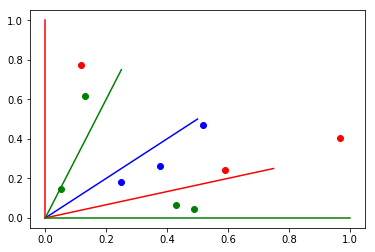

In [33]:
for i, r in enumerate(reference_points):
    if i%3 == 0:
        c='r'
    elif i%3 == 1:
        c='g'
    else:
        c='b'
    plt.plot([ 0, r[0]], [0, r[1]], c)
    
for i in range(assoc.shape[0]):
    if assoc[i,0]%3 == 0:
        c='r'
    elif assoc[i,0]%3 == 1:
        c='g'
    else:
        c='b'
    plt.scatter(initial_coords[i,0], initial_coords[i,1], c=c)
    
plt.show()

In [88]:
def niche(ref_count, assoc, K):
    out = []
    
    
    k = 1
    while k <= K:
        J = np.argwhere(ref_count==np.min(ref_count)).T[0]
        
        j = np.random.choice(J)
        I = np.argwhere(assoc[:,0]==j).T[0]
        if I.shape[0] != 0:
            out.append(np.random.choice(I))
        
        k+=1
    return out

niche(ref_count, assoc, 1)

[8]

In [63]:
a = np.argwhere(ref_count[1:]==np.min(ref_count[1:])).T[0]

In [43]:
help(np.argwhere)

Help on function argwhere in module numpy:

argwhere(a)
    Find the indices of array elements that are non-zero, grouped by element.
    
    Parameters
    ----------
    a : array_like
        Input data.
    
    Returns
    -------
    index_array : ndarray
        Indices of elements that are non-zero. Indices are grouped by element.
    
    See Also
    --------
    where, nonzero
    
    Notes
    -----
    ``np.argwhere(a)`` is the same as ``np.transpose(np.nonzero(a))``.
    
    The output of ``argwhere`` is not suitable for indexing arrays.
    For this purpose use ``nonzero(a)`` instead.
    
    Examples
    --------
    >>> x = np.arange(6).reshape(2,3)
    >>> x
    array([[0, 1, 2],
           [3, 4, 5]])
    >>> np.argwhere(x>1)
    array([[0, 2],
           [1, 0],
           [1, 1],
           [1, 2]])



In [76]:
np.random.choice(a)

3

array([[4, 9]])